Implementation of a Fearnet Variation

Authors: Brady Gho, Lucy Wu

Source: https://arxiv.org/abs/1711.10563

Created on July 25, 2024. Last edited July 25, 2024

# Defining Imports and Meta-parameters

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import numpy as np
import torch.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset

In [13]:
# Define meta-Parameters
Mini_batch = 450
Dropout = 0.25
VAE_dims = np.array([256])
Classifier_Dims = np.array([961, 525, 289, 100])
Input_Dim = 2048
Learning_Rate = 2e-3
HC_Epochs = 25
mPFC_Epochs = 35
BLA_Epochs = 15

# Loading and Processing Data

100%|██████████| 169001437/169001437 [00:01<00:00, 93225200.20it/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Train Loader Images:


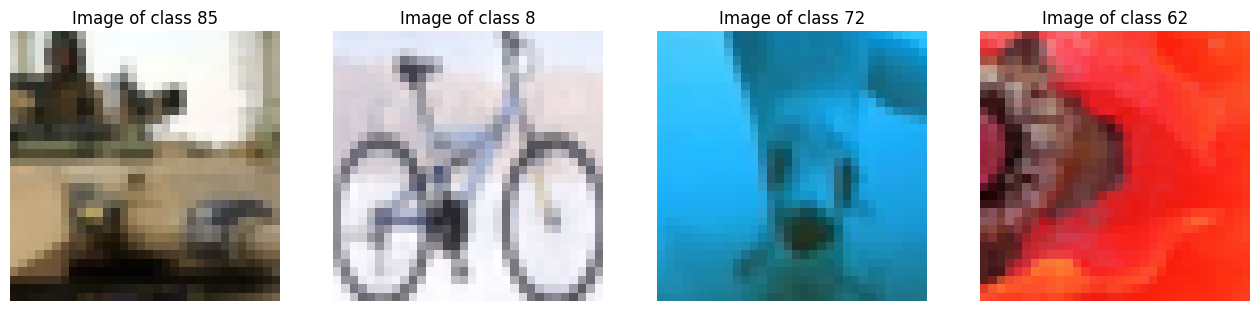

In [14]:
# Load Dataset (CIFAR-100)

transform = transforms.Compose([
    transforms.ToTensor(),
    # insert more transformations of data i.e. normalization
])

train_data = torchvision.datasets.CIFAR100(root='./data', train=True, transform = transform, download = True)
test_data = torchvision.datasets.CIFAR100(root='./data', train=False, transform = transform, download = True)

train_loader = DataLoader(train_data, batch_size = Mini_batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size = Mini_batch, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# view a couple of sample images to make sure they are loaded

print("Train Loader Images:")
images, labels = next(iter(train_loader))
images = images.cpu().detach().numpy()
plt.figure(figsize=(16, 4))
for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow(np.transpose(images[i], (1, 2, 0)))
  plt.axis('off')
  plt.title(f"Image of class {labels[i].item()}")
plt.show()


In [15]:
# Resnet Processing

from torchvision.models import resnet50

resnet = resnet50(pretrained=True)
resnet = resnet.to(device)
resnet.eval()

# remove all fc layers except the last one
resnet_feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


In [16]:
# pass data through Resnet processing
class CIFAR100FeatureDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

# training data
num_images = len(train_data)
feature_vectors = torch.zeros((num_images, 2048), device=device)
labels = torch.zeros(num_images, device=device)

feature_dataset = CIFAR100FeatureDataset(train_data)
feature_loader = DataLoader(feature_dataset, batch_size=Mini_batch, shuffle=False)

with torch.no_grad():
    for i, (images, labels_batch) in enumerate(feature_loader):
        images = images.to(device)
        labels_batch = labels_batch.to(device)
        features_batch = resnet_feature_extractor(images).squeeze()
        start_index = i * Mini_batch
        end_index = start_index + features_batch.shape[0]
        feature_vectors[start_index:end_index] = features_batch
        labels[start_index:end_index] = labels_batch

feature_vectors = torch.tensor(feature_vectors, dtype=torch.float32).to(device)
labels = torch.tensor(labels).long().to(device)

print("Training features shape:", feature_vectors.shape)
print("Training labels shape:", labels.shape)

# testing data
num_images = len(test_data)
test_feature_vectors = torch.zeros((num_images, 2048), device=device)
test_labels = torch.zeros(num_images, device=device)

test_feature_dataset = CIFAR100FeatureDataset(test_data)
test_feature_loader = DataLoader(test_feature_dataset, batch_size=Mini_batch, shuffle=False)

with torch.no_grad():
    for i, (images, labels_batch) in enumerate(test_feature_loader):
        images = images.to(device)
        labels_batch = labels_batch.to(device)
        features_batch = resnet_feature_extractor(images).squeeze()
        start_index = i * Mini_batch
        end_index = start_index + features_batch.shape[0]
        test_feature_vectors[start_index:end_index] = features_batch
        test_labels[start_index:end_index] = labels_batch

test_feature_vectors = torch.tensor(test_feature_vectors, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_labels).long().to(device)

print("Test features shape:", test_feature_vectors.shape)
print("Test labels shape:", test_labels.shape)

<ipython-input-16-876542bac5b9>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_vectors = torch.tensor(feature_vectors, dtype=torch.float32).to(device)
<ipython-input-16-876542bac5b9>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training features shape: torch.Size([50000, 2048])
Training labels shape: torch.Size([50000])
Test features shape: torch.Size([10000, 2048])
Test labels shape: torch.Size([10000])


<ipython-input-16-876542bac5b9>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_feature_vectors = torch.tensor(test_feature_vectors, dtype=torch.float32).to(device)
<ipython-input-16-876542bac5b9>:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).long().to(device)


In [17]:
class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels.long()

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

dataset = FeatureDataset(feature_vectors, labels)

# Evaluate the Performance of Resnet on CIFAR-100

In [18]:
resnet_test = resnet50(pretrained=True)
num_features = resnet_test.fc.in_features
resnet_test.fc = nn.Linear(num_features, 100)
resnet_test.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_test.parameters(), lr=0.001)

# training function
def training_step(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(data_loader)
    return average_loss

# calculate accuracy
def calculate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# training
num_epochs = 30
for epoch in range(num_epochs):
    avg_loss = training_step(resnet_test, train_loader, criterion, optimizer, device)
    accuracy = calculate_accuracy(resnet_test, test_loader, device)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {accuracy}%")

In [ ]:
# test accuracy

def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate the model
test_accuracy = evaluate_model(resnet_test, test_loader, device)
print(f'Test Accuracy of the model on the 10000 test images: {test_accuracy:.2f}%')


Test Accuracy of the model on the 10000 test images: 57.72%


# Hippocampus Implementation

In [8]:
# define HC

class HC(nn.Module):
  def __init__(self, input_dim=Input_Dim, classifier_dims = Classifier_Dims, learning_rate= Learning_Rate, p_dropout=Dropout):
    super(HC, self).__init__()

    self.short_term_memory = []

    classifier_layers = []
    current_dim = input_dim

    if len(classifier_dims)!=1:
      # Avoid dropping out the first layer of processing and output layer
      classifier_layers.append(nn.Linear(current_dim, classifier_dims[0]))
      classifier_layers.append(nn.ReLU())

      for i in range(1, len(classifier_dims)-1):
        hidden_dim = classifier_dims[i]
        classifier_layers.append(nn.Linear(current_dim, hidden_dim))
        classifier_layers.append(nn.ReLU())
        classifier_layers.append(nn.Dropout(p=p_dropout))
        current_dim = hidden_dim

    classifier_layers.append(nn.Linear(current_dim, classifier_dims[len(classifier_dims)-1]))

    self.classifier = nn.Sequential(*classifier_layers)

    # Using Adam Optimizer
    self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)

  def forward(self, x):
    self.short_term_memory.append(x)
    class_logits = self.classifier(x)
    return class_logits

  def clear_memory(self):
    memory = self.short_term_memory
    self.short_term_memory = []
    return memory

  def training_step(self, dataloader):
    total_loss = 0

    self.train()
    for features, targets in dataloader:
      # classification loss
      optimizer = self.optimizer
      optimizer.zero_grad()

      class_logits = self.forward(features)
      loss = nn.CrossEntropyLoss()(class_logits, targets)

      loss.backwards()
      optimizer.step()

      loss += total_loss

    return (total_loss / (len(dataloader) * dataloader.batch_size))

In [11]:
hippocampus = HC()

loss_history = []
for epoch in range(25):
  loss = hippocampus.training_step(data_loader)
  loss_history.append(loss)
  print(f"Loss at epoch {epoch+1}: {loss}")

plt.plot(loss_history)

NameError: name 'data_loader' is not defined

# Pre-frontal Cortex  Implementation

In [ ]:
# define mPFC (long term)

class mPFC(nn.Module):
  def __init__(self, input_dim=Input_Dim, autoencoder_hidden_dims = np.array([1024, 512]), classifier_dims = np.array([100]), lambda_values=[1e4, 1, 0.1], learning_rate=5e-4):
    super(mPFC, self).__init__()

    # encoder
    encoder_layers = []
    current_dim = input_dim
    encoder_layers.append(nn.ELU())
    for hidden_dim in autoencoder_hidden_dims:
      encoder_layers.append(nn.Linear(current_dim, hidden_dim))
      encoder_layers.append(nn.ELU())
      current_dim = hidden_dim
    self.encoder = nn.Sequential(*encoder_layers)

    # decoder
    decoder_layers = []
    hidden_dims_reversed = list(autoencoder_hidden_dims[::-1])
    for hidden_dim in hidden_dims_reversed:
      decoder_layers.append(nn.Linear(current_dim, hidden_dim))
      decoder_layers.append(nn.ELU())
      current_dim = hidden_dim
    decoder_layers.append(nn.Linear(current_dim, input_dim))
    decoder_layers.append(nn.ELU())
    self.decoder = nn.Sequential(*decoder_layers)

    #classifier
    current_dim = autoencoder_hidden_dims[-1]
    classifier_layers= []

    if len(classifier_dims) != 1:
      classifier_layers.append(nn.Linear(current_dim, classifier_dims[0]))
      classifier_layers.append(nn.ELU())
      current_dim = classifier_dims[0]

      for i in range(1, len(classifier_dims)-1):
        hidden_dim = classifier_dims[i]
        classifier_layers.append(nn.Linear(current_dim, hidden_dim))
        classifier_layers.append(nn.ELU())
        classifier_layers.append(nn.Dropout(p=Dropout))
        current_dim = hidden_dim

    classifier_layers.append(nn.Linear(current_dim, classifier_dims[len(classifier_dims)-1]))

    self.classifier = nn.Sequential(*classifier_layers)

    # lambda
    self.lambda_values = torch.tensor(lambda_values if lambda_values else [1.0] * len(autoencoder_hidden_dims), dtype=torch.float32)

    # optimizer
    self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

  def encoder_forward(self, x):
    encoder_intermediates = [x]
    for layer in self.encoder:
      x = layer(x)
      encoder_intermediates.append(x)
    encoded = encoder_intermediates[-1]
    return encoded, encoder_intermediates

  def decoder_forward(self, x):
    decoder_intermediates = [x]
    for layer in self.decoder:
      x = layer(x)
      decoder_intermediates.append(x)
    pseudo_img = decoder_intermediates[-1]
    return pseudo_img, list(decoder_intermediates[::-1])

  def classify(self, x):
    class_logits = self.classifier(x)
    return class_logits

  def compute_loss(self, class_logits, targets, encoder_intermediates, decoder_intermediates):

    # classification loss
    classification_loss = nn.CrossEntropyLoss()(class_logits, targets)

    # reconstruction loss with lambda weighting
    reconstruction_loss = 0
    for i in range(len(self.lambda_values)):
      encoder_hidden = encoder_intermediates[i]
      decoder_hidden = decoder_intermediates[i]
      diff = encoder_hidden - decoder_hidden
      squared_diff = diff.pow(2)
      layer_loss = squared_diff.sum()
      reconstruction_loss += self.lambda_values[i] * layer_loss

    # total loss
    total_loss = classification_loss + reconstruction_loss

    return classification_loss, reconstruction_loss, total_loss

  def training_step(self, data_loader, device):
    self.train()

    total_classification_loss = 0
    total_reconstruction_loss = 0
    total_total_loss = 0

    for x, targets in data_loader:
      x, targets = x.to(device), targets.to(device)

      # forward pass
      encoded, encoder_intermediates = self.encoder_forward(x)
      pseudo_img, decoder_intermediates = self.decoder_forward(encoded)
      class_logits = self.classify(encoded)

      # compute losses
      classification_loss, reconstruction_loss, total_loss = self.compute_loss(
        class_logits, targets, encoder_intermediates, decoder_intermediates
      )

      # zero gradients
      self.optimizer.zero_grad()

      # backward pass
      classification_loss.backward(retain_graph=True)
      classifier_grads = {name: param.grad.clone() for name, param in self.classifier.named_parameters()}
      reconstruction_loss.backward(retain_graph=True)
      decoder_grads = {name: param.grad.clone() for name, param in self.decoder.named_parameters()}
      total_loss.backward()
      encoder_grads = {name: param.grad.clone() for name, param in self.encoder.named_parameters()}

      # optimizer
      encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=self.optimizer.defaults['lr'])
      encoder_optimizer.step()
      classifier_optimizer = optim.Adam(self.classifier.parameters(), lr=self.optimizer.defaults['lr'])
      classifier_optimizer.step()
      decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=self.optimizer.defaults['lr'])
      decoder_optimizer.step()

      # update parameters
      for name, param in self.classifier.named_parameters():
        if param.grad is not None:
          param.grad.data = classifier_grads[name].data
      for name, param in self.decoder.named_parameters():
        if param.grad is not None:
          param.grad.data = decoder_grads[name].data
      for name, param in self.encoder.named_parameters():
        if param.grad is not None:
          param.grad.data = encoder_grads[name].data

      # add losses to total
      total_classification_loss += classification_loss.item()
      total_reconstruction_loss += reconstruction_loss.item()
      total_total_loss += total_loss.item()

    # average loss
    average_classification_loss = total_classification_loss / len(data_loader)
    average_reconstruction_loss = total_reconstruction_loss / len(data_loader)
    average_total_loss = total_total_loss / len(data_loader)

    return average_classification_loss, average_reconstruction_loss, average_total_loss

  def generate_statistics(self, list_feature_vectors, device):
    self.eval()

    latent_rep = []

    with torch.no_grad():
      for x, targets in list_feature_vectors:
        x, targets = x.to(device), targets.to(device)

        # pass through encoder
        mPFC_out, _ = self.encoder_forward(x)
        latent_rep.append(mPFC_out.cpu())

    # stack
    latent_rep = torch.cat(latent_rep, dim=0)

    # ux
    ux_mPFC = latent_rep.mean(dim=0)

    # covariance matrix
    centered_mPFC_features = latent_rep - ux_mPFC
    covariance_matrix_mPFC = torch.matmul(centered_mPFC_features.t(), centered_mPFC_features) / (latent_rep.size(0) - 1)

    return ux_mPFC, covariance_matrix_mPFC

  def pseudoimg_from_statistics(self, u, covar, count):
    self.eval()

    # sampling from a multivariate normal distribution
    distribution = torch.distributions.MultivariateNormal(u, covar)
    sampled_vectors = distribution.sample((count,)).to(device)

    # pass through decoder
    pseudo_images = []
    with torch.no_grad():
      for latent_vector in sampled_vectors:
        pseudo_img, _ = self.decoder_forward(latent_vector)
        pseudo_images.append(pseudo_img.cpu())

    # stack
    pseudo_images = torch.stack(pseudo_images, dim=0)

    return pseudo_images

  def calculate_accuracy(self, data_loader, device):
    self.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for x, targets in data_loader:
        x, targets = x.to(device), targets.to(device)
        encoded, _ = self.encoder_forward(x)
        class_logits = self.classify(encoded)
        _, predicted = torch.max(class_logits.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# BLA Implementation

In [6]:
# Define BLA

class BLA(nn.Module):

  def __init__(self, input_dim=Input_Dim, classifier_dims = Classifier_Dims, learning_rate= Learning_Rate, p_dropout=Dropout):
    super(BLA, self).__init__()

    classifier_layers = []
    current_dim = input_dim

    if len(classifier_dims)!=1:
      # Avoid dropping out the first layer of processing and output layer
      classifier_layers.append(nn.Linear(current_dim, classifier_dims[0]))
      classifier_layers.append(nn.ReLU())

      for i in range(1, len(classifier_dims)):
        hidden_dim = classifier_dims[i]
        classifier_layers.append(nn.Linear(current_dim, hidden_dim))
        classifier_layers.append(nn.ReLU())
        classifier_layers.append(nn.Dropout(p=p_dropout))
        current_dim = hidden_dim

    classifier_layers.append(nn.Linear(current_dim, 1))

    self.classifier = nn.Sequential(*classifier_layers)

    # Using Adam Optimizer
    self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)


  def forward(self, x):
    class_logits = self.classifier(x)
    return class_logits

  def training_step(self, dataloader, HC, mPFC):
    total_loss = 0

    self.train()
    HC.eval()
    mPFC.eval()
    for features, label in dataloader:
      HC_logits = []
      mPFC_logits = []

      with torch.no_grad():
        HC_logits = HC.forward(features)
        mPFC_logits = mPFC.forward(features)

      optimizer = self.optimizer
      optimizer.zero_grad()

      class_prob = self.Softmax(self.forward(features))

      # class_prob =

      HC_prob = nn.Softmax(HC_logits)
      mPFC_prob = nn.Softmax(mPFC_logits)

      loss_fn = nn.CrossEntropyLoss()

      # <--- implementation is wrong ---->

      HC_loss = loss_fn(HC_prob, labels)
      mPFC_loss = loss_fn(mPFC_prob, labels)

      # Determine if HC or mPFC is more accurate
      target_is_HC = HC_loss < mPFC_loss
      target_is_HC = target_is_HC.float().view(-1, 1)  # Convert to float and reshape for broadcasting

      # Calculate the BLA loss based on whether the prediction aligns with the more accurate model
      BLA_target = target_is_HC
      BLA_loss = nn.BCELoss()(class_prob, BLA_target)

      # <--- implementation is wrong ---->

      BLA_loss.backwards()
      optimizer.step()

      total_loss += BLA_loss

    return (total_loss / (len(dataloader) * dataloader.batch_size))

Bla = BLA()

# Dual Memory System Model

In [ ]:
# dmsm

class DMSM(nn.Module):
  def __init__(self, input_dim=Input_Dim, classifier_dims = Classifier_Dims, learning_rate=Learning_Rate, p_dropout=Dropout, lambda_values = [1e4, 1.0, 0.1]):
    super(DMSM, self).__init__()
    self.mPFC = mPFC(input_dim, np.array([1024, 512]), classifier_dims, lambda_values, learning_rate)
    self.HC = HC(input_dim, classifier_dims, learning_rate, p_dropout)
    self.BLA()

  def training(self, dataloader, HCepochs = HC_Epochs, BLAepochs = BLA_Epochs):
    mPFC = self.mPFC
    HC = self.HC
    BLA = self.BLA

    HC_loss_history = []
    BLA_loss_history = []

    # Train HC

    for epoch in range(HC_Epochs):
      loss = self.hc.back_prop(features, targets)
      HC_loss_history.append(loss)


    # Train BLA
    for epoch in range(BLA_Epochs):
      BLA.training_step

  def sleep(self, dataloader, mPFC_Epochs = mPFC_Epochs):
    mPFC = self.mPFC
    HC = self.HC
    BLA = self.BLA

    mPFC_loss = []

    # Integrate hallucinated images into the dataloader
    #
    #
    #
    #


    for epoch in range(mPFC_Epochs):
      mPFC_Epochs.training_step(dataloader)

  def eval(self, dataloader):
    mPFC = self.mPFC
    HC = self.HC
    BLA = self.BLA

    BLA.eval()
    HC



DMSM()

In [ ]:
# Training

a = torch.tensor([1, 2, 3, 4])
print(a[[0, 2]])